## Import libraries and dataset

In [40]:
!python -V

Python 3.6.3 :: Anaconda custom (64-bit)


In [41]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

print('pandas version:', pd.__version__)

pandas version: 0.22.0


In [42]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [43]:
data_train = pd.read_csv('../data/cardiac_data_train_35609_rows.csv')
# all operations done on training data should be in synch with the test data
data_test = pd.read_csv('../data/cardiac_data_test_3957_rows.csv')

data_train.shape, data_test.shape

((35609, 63), (3957, 63))

In [44]:
pd.set_option('display.max_columns', data_train.shape[1])

## EDA  on training set

Check missing value status

In [45]:
def show_na_info(df, missing_only = False):
    rlt = pd.DataFrame({'count' : df.isnull().sum(), 
              'percent' : df.isnull().sum() / df.shape[0] * 100})
    if missing_only:
        rlt = rlt[rlt['count'] > 0]
    return rlt[['count', 'percent']]

In [46]:
show_na_info(data_train).sort_values('percent', ascending=False)

,count,percent
preg_stat,31251,87.761521
height,28485,79.993822
weight,26777,75.197282
hmgnlo,10946,30.739420
platlo,10922,30.672021
iddm,10682,29.998034
hmgnhi,8989,25.243618
plathi,8858,24.875734
hctlo,6365,17.874695
wcclo,5116,14.367154


`weight`, `height` and `preg_stat` have too many missing values(all over 65%.)  
They seem not worth keeping - let's explore the distribution.

In [47]:
data_na_heavy = data_train[['weight', 'height', 'preg_stat', 'died_hosp']]
data_na_heavy.describe()

,weight,height,preg_stat,died_hosp
count,8832.000000,7124.000000,4358.000000,35609.000000
mean,83.642206,170.786356,2.012620,0.455419
std,22.977049,11.889323,0.193007,0.498016
min,3.200000,15.000000,1.000000,0.000000
25%,70.000000,165.000000,2.000000,0.000000
50%,80.000000,171.000000,2.000000,0.000000
75%,95.000000,178.000000,2.000000,1.000000
max,240.000000,235.000000,3.000000,1.000000


In [48]:
def plot_class_broke_down_hist(df, var, xlog=False, ylog=False, **histkwargs):
    df[var][df.died_hosp == 0].hist(alpha=.5, label='survived', **histkwargs)
    df[var][df.died_hosp == 1].hist(alpha=.5, label='died', **histkwargs)
    plt.xlabel(var)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.legend();

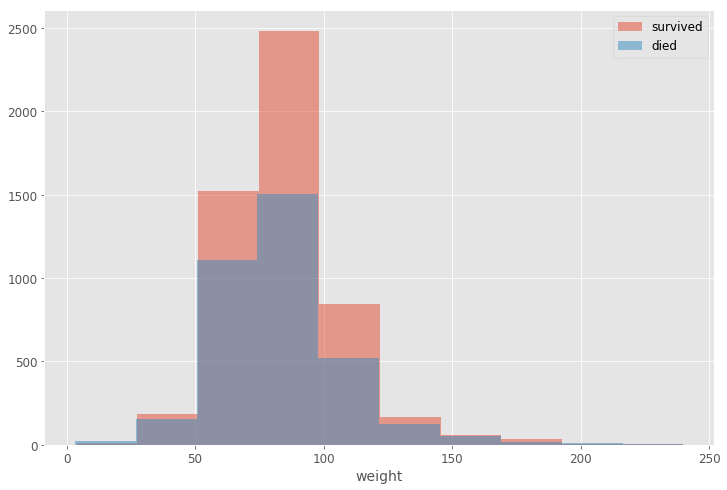

In [49]:
plot_class_broke_down_hist(data_na_heavy, 'weight')

There doesn't seem any discernible pattern for the distribution of the weight over hospital outcome. This means weight alone doesn't provide much information to predict mortality. 

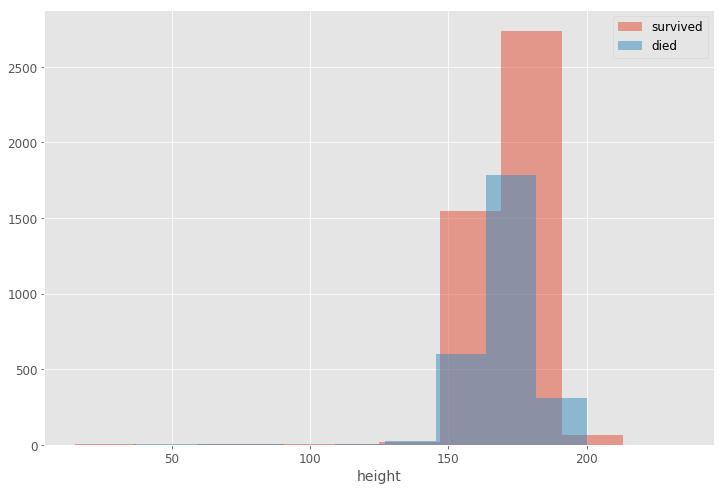

In [50]:
plot_class_broke_down_hist(data_na_heavy, 'height')

Same issue as weight

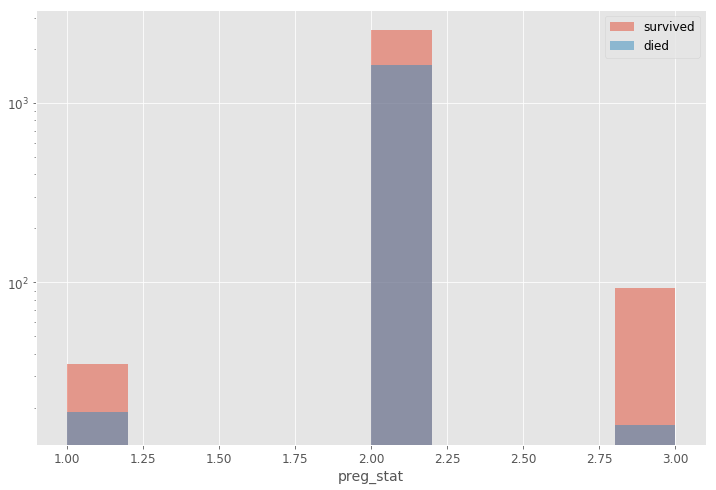

In [51]:
plot_class_broke_down_hist(data_na_heavy, 'preg_stat', ylog=True)

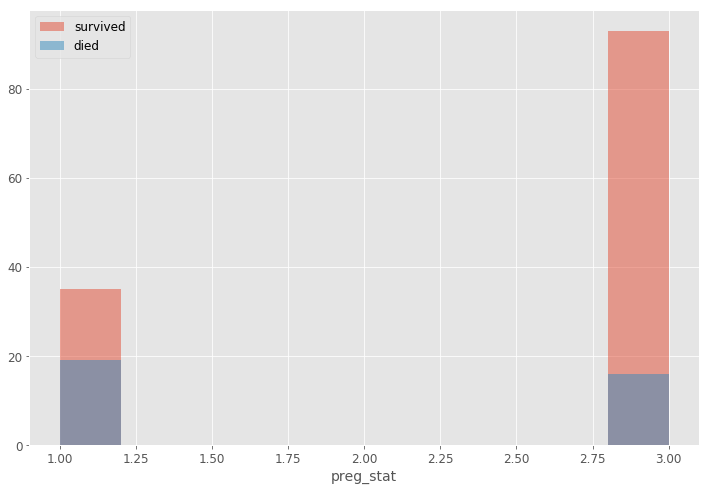

In [52]:
plot_class_broke_down_hist(data_na_heavy.query('preg_stat != 2'), 'preg_stat')

Different pregnancy statuses show no huge difference difference, but there are handful of cases here. For a categorical variable, the missing value will be assigned to the most common status which is not pregnant, and it shows no information for prediction.

In [53]:
data_na_heavy.corr()

,weight,height,preg_stat,died_hosp
weight,1.000000,0.304684,0.009227,-0.026813
height,0.304684,1.000000,0.007468,-0.049309
preg_stat,0.009227,0.007468,1.000000,-0.058738
died_hosp,-0.026813,-0.049309,-0.058738,1.000000


The corralation between the predictors and the target shows very little linear relationship. 

So I feel pretty comfortable to drop these variables with high level missing values.

We also need to remove aids because there are only a small number (in the dataset.

In [54]:
vars_to_remove = ['weight', 'height', 'preg_stat', 'aids']
def remove_variables(df, vars_to_remove):
    df.drop(vars_to_remove, axis=1, inplace=True, errors='ignore')

In [55]:
remove_variables(data_test, vars_to_remove)
remove_variables(data_train, vars_to_remove)
show_na_info(data_train)

,count,percent
sex,0,0.000000
age,2,0.005617
chr_resp,0,0.000000
chr_cvs,0,0.000000
chr_liv,0,0.000000
chr_ren,0,0.000000
immundis,0,0.000000
immunrx,0,0.000000
hepfail,0,0.000000
lymphoma,0,0.000000


**Check outliers or errors and explore imputation stragety**

_check `age`_

In [56]:
data_train.age.describe()

count    35607.000000
mean        61.479800
std         17.471245
min          0.100000
25%         50.900002
50%         64.199997
75%         75.000000
max        110.000000
Name: age, dtype: float64

In [57]:
data_train.age.head()

0    56.200001
1    52.610001
2    27.900000
3    69.599998
4    83.800003
Name: age, dtype: float64

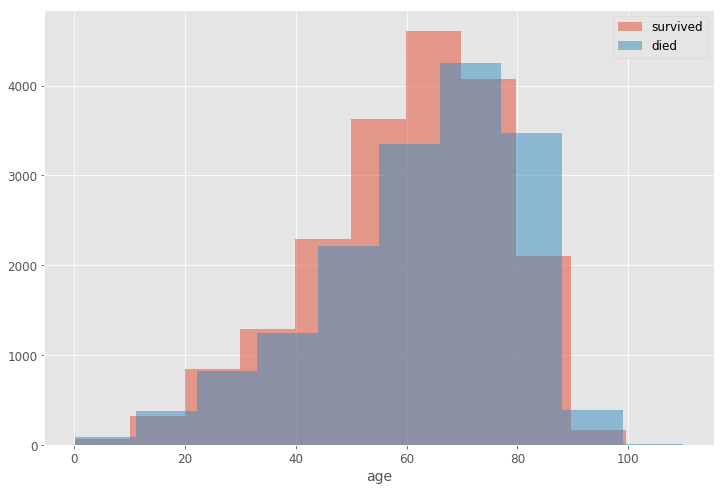

In [58]:
plot_class_broke_down_hist(data_train, 'age', bins=10);

Seems like age is recorded with a precision to month. Youngest is 0.1 years old, and the oldest is 99.7 years old. No errors found.
The histogram shows patients who are less than 60 years old have better chance surviving.

Let's check out our young patients

In [59]:
data_train[data_train.age <= 10].describe(include='all')

,sex,age,chr_resp,chr_cvs,chr_liv,chr_ren,immundis,immunrx,hepfail,lymphoma,metast,leukaem,immunsup,cirrhos,iddm,elect,pre_icu_hrs,intubated,ventilated,arf,gcsverb,gcsmotor,gcseye,gcs,urineop,temphi,templo,hrhi,hrlo,rrhi,rrlo,systolichi,systoliclo,diastolichi,diastoliclo,maphi,maplo,nahi,nalo,khi,klo,hco3hi,hco3lo,creathi,creatlo,hcthi,hctlo,hmgnhi,hmgnlo,wcchi,wcclo,plathi,platlo,gluchi,gluclo,apache3riskofdeath,anzrodriskofdeath,apache3score,died_hosp
count,148,148.000000,148.000000,148.000000,148.0,148.0,148.0,148.0,148.0,148.0,148.0,148.0,148.0,148.0,100.0,148.000000,148.000000,148.000000,148.000000,147.000000,45.000000,45.000000,45.000000,45.000000,34.000000,45.000000,42.000000,45.000000,43.000000,46.000000,44.000000,40.000000,39.000000,39.000000,38.000000,41.000000,40.000000,43.000000,37.000000,42.000000,36.000000,38.000000,33.000000,40.000000,34.000000,34.000000,28.000000,26.000000,23.000000,40.000000,33.000000,25.000000,22.000000,33.000000,30.000000,46.000000,46.000000,46.000000,148.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.946622,0.033784,0.033784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047297,6.312500,0.189189,0.189189,0.040816,2.777778,3.377778,2.422222,8.577778,1059.294118,37.084445,35.047619,136.800000,89.488372,33.804348,20.795455,116.825000,80.846154,66.384615,46.789474,84.317073,58.350000,139.976744,137.108108,5.173810,4.069444,20.305263,16.484848,81.800000,71.323529,0.343529,0.304286,11.461538,10.243478,17.045000,12.260606,249.800000,200.636364,11.578788,6.200000,0.417633,0.300392,83.891304,0.567568
std,NaN,2.792590,0.181286,0.181286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212995,23.140022,0.392989,0.392989,0.198541,1.975864,2.424205,1.469213,5.646756,994.221655,1.523148,1.899838,44.986665,35.275360,15.515755,12.227646,26.171905,24.797643,18.050536,14.084989,20.051732,17.030214,6.100306,5.998999,1.485057,0.828016,6.811594,5.523762,45.904695,38.058743,0.076272,0.082795,2.917407,3.254762,10.038744,6.419401,111.068672,103.666381,5.849773,2.954716,0.328728,0.282459,43.036020,0.497096
min,NaN,0.100000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,32.599998,30.100000,50.000000,1.000000,10.000000,1.000000,50.000000,24.000000,16.000000,18.000000,31.000000,21.000000,123.000000,123.000000,3.300000,2.800000,7.200000,4.200000,27.000000,15.000000,0.150000,0.150000,4.700000,4.500000,4.700000,3.500000,98.000000,39.000000,4.900000,1.400000,0.001564,0.001324,13.000000,0.000000
25%,NaN,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,300.000000,36.500000,33.725001,104.000000,67.500000,22.500000,13.750000,104.750000,69.000000,55.000000,39.250000,73.000000,50.000000,137.000000,134.000000,4.225000,3.450000,17.250000,13.000000,43.500000,42.000000,0.302500,0.240000,10.150000,8.450000,9.775000,7.100000,182.000000,131.000000,6.600000,4.825000,0.082464,0.050067,43.750000,0.000000
50%,NaN,1.450000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.541666,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,6.000000,750.000000,37.000000,35.850001,140.000000,90.000000,30.000000,18.000000,111.000000,86.000000,70.000000

In [60]:
data_train.loc[data_train.age <= 10, 'died_hosp'].value_counts()

1.0    84
0.0    64
Name: died_hosp, dtype: int64

There are 148 young patients(< 10 yrs), and their survival rate is 40/60 - fairly similar to the entire group. They have high percentage of missing values in `hmgnhi` and `hmgnlo`

I wouldn't discard these 148 young patients as outliers as they have pretty complete records.

Check the mortality in different age groups.

Based on the histogram, age might be broken down to  
_< 30_, 
_30 - 40_,
_40 - 50_,
_50 - 60_,
_60 - 70_,
_70 - 80_,
_> 80_

In [61]:
data_train.loc[data_train.age < 30, 'died_hosp'].mean()

0.4464928057553957

Let's check the mortality ratio by age group

In [62]:
data_train[data_train.age >= 30].assign(age_group = data_train.age // 10 * 10)[['age_group', 'died_hosp']].groupby('age_group').mean()

,died_hosp
age_group,
30.0,0.433979
40.0,0.402881
50.0,0.401739
60.0,0.437095
70.0,0.488398
80.0,0.554885
90.0,0.522388
100.0,1.000000
110.0,1.000000


In [63]:
data_train[data_train.age >= 30].assign(age_group = data_train.age // 10 * 10)[['age_group', 'died_hosp']].groupby('age_group').count()

,died_hosp
age_group,
30.0,2272
40.0,3887
50.0,6096
60.0,8179
70.0,7973
80.0,4637
90.0,335
100.0,3
110.0,1


So roughly as age progresses upward by one group, the mortality goes up by 3-5% (until our elderly patients).
This provides a simple missing value imputation strategy that is based on age group (idea is people tent to have similar biological attributes and medical measurements when they are similar in age and have the same in-hospital survival outcome).

We'll group all patients aged over 80 into onen age category

In [64]:
data_test['age_group'] = data_test.age.apply(lambda x: '[0, 30)' if x < 30 else '[30, 40)' if x < 40 else '[40, 50)' if x < 50 else '[50, 60)' if x < 60 else '[60, 70)' if x < 70 else '[70, 80)' if x < 80 else '[80,)')
data_train['age_group'] = data_train.age.apply(lambda x: '[0, 30)' if x < 30 else '[30, 40)' if x < 40 else '[40, 50)' if x < 50 else '[50, 60)' if x < 60 else '[60, 70)' if x < 70 else '[70, 80)' if x < 80 else '[80,)')
data_train.age_group.value_counts()

[60, 70)    8179
[70, 80)    7973
[50, 60)    6096
[80,)       4978
[40, 50)    3887
[30, 40)    2272
[0, 30)     2224
Name: age_group, dtype: int64

_Check categorical variables_

In [65]:
data_train.columns.values

array(['sex', 'age', 'chr_resp', 'chr_cvs', 'chr_liv', 'chr_ren',
       'immundis', 'immunrx', 'hepfail', 'lymphoma', 'metast', 'leukaem',
       'immunsup', 'cirrhos', 'iddm', 'elect', 'pre_icu_hrs', 'intubated',
       'ventilated', 'arf', 'gcsverb', 'gcsmotor', 'gcseye', 'gcs',
       'urineop', 'temphi', 'templo', 'hrhi', 'hrlo', 'rrhi', 'rrlo',
       'systolichi', 'systoliclo', 'diastolichi', 'diastoliclo', 'maphi',
       'maplo', 'nahi', 'nalo', 'khi', 'klo', 'hco3hi', 'hco3lo',
       'creathi', 'creatlo', 'hcthi', 'hctlo', 'hmgnhi', 'hmgnlo',
       'wcchi', 'wcclo', 'plathi', 'platlo', 'gluchi', 'gluclo',
       'apache3riskofdeath', 'anzrodriskofdeath', 'apache3score',
       'died_hosp', 'age_group'], dtype=object)

In [66]:
categorical_vars = ['sex', 'chr_resp', 'chr_cvs', 'chr_liv', 'chr_ren',
       'immundis', 'immunrx', 'hepfail', 'lymphoma', 'metast',
       'leukaem', 'immunsup', 'cirrhos', 'iddm', 'arf', 'gcsverb',
       'gcsmotor', 'gcseye', 'gcs', 'intubated', 'ventilated', 'elect']

In [67]:
data_train[categorical_vars].describe(include='all')

,sex,chr_resp,chr_cvs,chr_liv,chr_ren,immundis,immunrx,hepfail,lymphoma,metast,leukaem,immunsup,cirrhos,iddm,arf,gcsverb,gcsmotor,gcseye,gcs,intubated,ventilated,elect
count,35609,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,35609.000000,24927.000000,35515.000000,33830.000000,33840.000000,33837.000000,33863.000000,35540.000000,35531.000000,34637.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,23274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.063439,0.128788,0.013817,0.046393,0.010503,0.025977,0.003819,0.005476,0.014800,0.007189,0.024994,0.013339,0.053155,0.135464,2.257257,2.893942,2.039365,7.191153,0.791559,0.790859,0.06161
std,NaN,0.243754,0.334969,0.116731,0.210337,0.101946,0.159068,0.061683,0.073799,0.120752,0.084485,0.156108,0.114725,0.224347,0.342223,1.777327,2.317332,1.364518,5.302735,0.406200,0.406701,0.24045
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.00000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.00000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.00000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000,4.000000,14.000000,1.000000,1.000000,0.00000


for variables `sex` to `arf` there seems to be no errors, and most patients don't have these chronic deseases nor Acute Renal Failure.

In [68]:
data_train.loc[
    ~data_train.gcs.isna() & (data_train.gcseye.isna() | data_train.gcsverb.isna() | data_train.gcsmotor.isna()), 
    ['gcsverb', 'gcsmotor', 'gcseye', 'gcs']]

,gcsverb,gcsmotor,gcseye,gcs
258,NaN,NaN,NaN,4.0
526,NaN,NaN,NaN,7.0
1947,NaN,NaN,NaN,10.0
3607,NaN,NaN,NaN,13.0
5231,NaN,NaN,NaN,6.0
5328,NaN,NaN,NaN,14.0
5360,NaN,NaN,NaN,8.0
5479,NaN,NaN,NaN,15.0
5810,NaN,NaN,NaN,11.0
6316,NaN,NaN,NaN,4.0


No errors found for `gcseye`, `gcsmotor`, `gcsverb` values.  
Unfortunately, knowing `gcs` is the sum of all of these three values doesn't help much. Most missing in gcs is resulted from missing in one of the three gcs scores. This amounts to the fact that gcs is redundant and needs to be removed.

In [69]:
del categorical_vars[categorical_vars.index('gcs')]
remove_variables(data_test, ['gcs'])
remove_variables(data_train, ['gcs'])
data_train.columns.values

array(['sex', 'age', 'chr_resp', 'chr_cvs', 'chr_liv', 'chr_ren',
       'immundis', 'immunrx', 'hepfail', 'lymphoma', 'metast', 'leukaem',
       'immunsup', 'cirrhos', 'iddm', 'elect', 'pre_icu_hrs', 'intubated',
       'ventilated', 'arf', 'gcsverb', 'gcsmotor', 'gcseye', 'urineop',
       'temphi', 'templo', 'hrhi', 'hrlo', 'rrhi', 'rrlo', 'systolichi',
       'systoliclo', 'diastolichi', 'diastoliclo', 'maphi', 'maplo',
       'nahi', 'nalo', 'khi', 'klo', 'hco3hi', 'hco3lo', 'creathi',
       'creatlo', 'hcthi', 'hctlo', 'hmgnhi', 'hmgnlo', 'wcchi', 'wcclo',
       'plathi', 'platlo', 'gluchi', 'gluclo', 'apache3riskofdeath',
       'anzrodriskofdeath', 'apache3score', 'died_hosp', 'age_group'],
      dtype=object)

In [70]:
data_train.gcsverb.value_counts(dropna=False)

 1.0    21887
 5.0     8985
NaN      1779
 4.0     1357
 3.0      921
 2.0      680
Name: gcsverb, dtype: int64

In [71]:
data_train.gcsmotor.value_counts(dropna=False)

 1.0    19596
 6.0    10716
NaN      1769
 5.0     1433
 4.0     1063
 3.0      558
 2.0      474
Name: gcsmotor, dtype: int64

In [72]:
data_train.gcseye.value_counts(dropna=False)

 1.0    20797
 4.0    10063
 3.0     2003
NaN      1772
 2.0      974
Name: gcseye, dtype: int64

In [74]:
data_train[data_train.gcsverb.isna() & data_train.gcsmotor.isna() & data_train.gcseye.isna()].shape

(1769, 59)

Interesting, if a patient is missing one gcs related score, they appear to miss all gcs related scores.

Let's check the class breakdown

In [75]:
data_train.loc[data_train.gcsverb.isna(), :].died_hosp.value_counts()

1.0    951
0.0    828
Name: died_hosp, dtype: int64

In [76]:
data_train.loc[data_train.gcsverb.isna(), :].age_group.value_counts()

[70, 80)    373
[60, 70)    359
[50, 60)    277
[80,)       271
[0, 30)     230
[40, 50)    161
[30, 40)    108
Name: age_group, dtype: int64

Missing value in gcs related scores doesn't show a particular pattern in terms of age group and survival rate.

In [77]:
pd.crosstab(data_train.gcsverb, data_train.age_group)

age_group,"[0, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80,)"
gcsverb,,,,,,,
1.0,1454,1521,2544,3901,5018,4678,2771
2.0,47,44,95,134,130,151,79
3.0,48,44,102,161,211,213,142
4.0,59,68,112,202,266,354,296
5.0,386,487,873,1421,2195,2204,1419


In [78]:
pd.crosstab(data_train.gcsmotor, data_train.age_group)

age_group,"[0, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80,)"
gcsmotor,,,,,,,
1.0,1302,1391,2334,3538,4509,4142,2380
2.0,49,28,59,77,108,96,57
3.0,43,29,77,98,117,98,96
4.0,57,68,106,180,219,269,164
5.0,81,78,143,229,318,352,232
6.0,463,571,1008,1698,2550,2647,1779


In [79]:
pd.crosstab(data_train.gcseye, data_train.age_group)

age_group,"[0, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80,)"
gcseye,,,,,,,
1.0,1434,1470,2446,3763,4754,4372,2558
2.0,44,54,108,146,221,250,151
3.0,94,102,180,312,441,529,345
4.0,423,538,993,1599,2403,2453,1654


gcs related scores show most patients are scored 1 across age groups.

_Check continuous variables_

In [80]:
def plot_age_group_broke_down_hist(df, var, xlog=False, ylog=False, **histkwargs):
    df[var][df.age_group == '[0, 30)'].hist(alpha=.5, label='[0, 60)', **histkwargs)    
    df[var][df.age_group == '[30, 40)'].hist(alpha=.5, label='[0, 60)', **histkwargs)    
    df[var][df.age_group == '[40, 50)'].hist(alpha=.5, label='[0, 60)', **histkwargs)    
    df[var][df.age_group == '[50, 60)'].hist(alpha=.5, label='[0, 60)', **histkwargs)    
    df[var][df.age_group == '[60, 70)'].hist(alpha=.5, label='[0, 60)', **histkwargs)
    df[var][df.age_group == '[70, 80)'].hist(alpha=.5, label='[60, 80)', **histkwargs)
    df[var][df.age_group == '[80,)'].hist(alpha=.5, label='[80,)', **histkwargs)    
    plt.xlabel(var)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.legend();

In [81]:
continuous_vars = ['age', 'urineop', 'temphi', 'templo', 'hrhi', 'hrlo',
       'rrhi', 'rrlo', 'systolichi', 'systoliclo', 'diastolichi',
       'diastoliclo', 'maphi', 'maplo', 'nahi', 'nalo', 'khi', 'klo',
       'hco3hi', 'hco3lo', 'creathi', 'creatlo', 'hcthi', 'hctlo',
       'hmgnhi', 'hmgnlo', 'wcchi', 'wcclo', 'plathi', 'platlo', 'gluchi',
       'gluclo', 'pre_icu_hrs']

In [82]:
data_train[continuous_vars].describe()

,age,urineop,temphi,templo,hrhi,hrlo,rrhi,rrlo,systolichi,systoliclo,diastolichi,diastoliclo,maphi,maplo,nahi,nalo,khi,klo,hco3hi,hco3lo,creathi,creatlo,hcthi,hctlo,hmgnhi,hmgnlo,wcchi,wcclo,plathi,platlo,gluchi,gluclo,pre_icu_hrs
count,35607.000000,32506.000000,32558.000000,31789.000000,33529.000000,32227.000000,33206.000000,32053.000000,32948.000000,31860.000000,31933.000000,30952.000000,33325.000000,32219.000000,33339.000000,31508.000000,33299.000000,31456.00000,32317.000000,30623.000000,33048.000000,30945.000000,31004.000000,29244.000000,26620.000000,24663.000000,32957.000000,30493.000000,26751.000000,24687.000000,32584.000000,31112.000000,35369.000000
mean,61.479800,1710.001384,36.911593,34.806368,104.843568,66.885407,22.352677,12.950488,144.122101,90.627307,73.672439,50.325084,97.748987,63.706229,140.075737,136.848578,4.746358,3.87447,22.194267,18.963466,156.699710,124.996575,0.380851,0.348009,12.702943,11.532328,17.513065,13.196095,234.744682,197.291570,12.544761,6.822807,83.354118
std,17.471245,1334.617723,1.336630,1.646050,25.694565,20.001534,7.838777,4.060400,29.335911,20.301427,17.462761,12.307127,19.676311,13.663952,4.853353,4.672431,0.878029,0.70087,5.063726,5.354594,148.413909,109.839946,0.073949,0.075678,2.507523,2.540395,11.672923,8.386155,102.489618,91.024866,6.054371,3.331899,1914.004903
min,0.100000,0.000000,25.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,1.600000,1.00000,2.000000,2.000000,10.000000,10.000000,0.050000,0.050000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.900002,800.000000,36.299999,33.700001,88.000000,54.000000,17.000000,10.000000,125.000000,80.000000,61.000000,43.000000,85.000000,57.000000,138.000000,135.000000,4.200000,3.40000,19.000000,16.000000,82.000000,68.000000,0.330000,0.290000,10.900000,9.700000,11.600000,8.700000,171.000000,141.000000,8.500000,5.100000,1.166666
50%,64.199997,1500.000000,37.000000,35.200001,102.000000,65.000000,21.000000,12.000000,141.000000,90.000000,71.000000,50.000000,96.000000,64.000000,140.000000,137.000000,4.600000,3.80000,22.100000,19.000000,113.000000,94.000000,0.380000,0.350000,12.800000,11.700000,15.800000,11.900000,223.000000,189.000000,11.100000,6.200000,3.083333
75%,75.000000,2345.000000,37.700001,36.000000,120.000000,80.000000,26.000000,15.000000,160.000000,100.000000,84.000000,58.000000,109.000000,71.000000,143.000000,140.000000,5.100000,4.20000,25.000000,22.000000,174.000000,140.000000,0.430000,0.400000,14.500000,13.400000,21.200001,16.000000,283.000000,241.000000,15.100000,7.600000,11.000000
max,110.000000,27090.000000,45.000000,41.599998,300.000000,240.000000,80.000000,80.000000,300.000000,294.000000,200.000000,143.000000,219.000000,168.000000,200.000000,168.000000,12.000000,10.90000,58.000000,60.000000,2500.000000,1790.000000,0.750000,0.750000,24.200001,22.400000,300.000000,300.000000,1500.000000,1500.000000,88.599998,62.000000,120528.000000


These variables have very different scales. They take on different means. By examination, they don't appear to have error values.

Check the distribution of some variables against age groups to see if there are distinction in them.

In [83]:
data_train.urineop.isnull().sum() / len(data_train) * 100

8.7140891347693

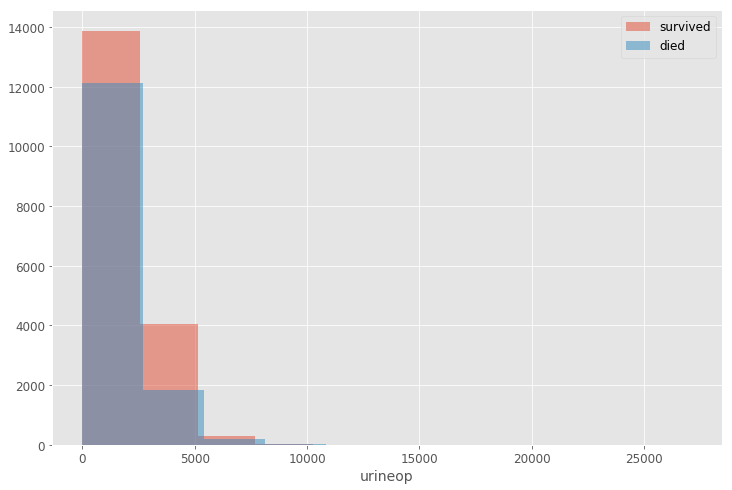

In [84]:
plot_class_broke_down_hist(data_train, 'urineop')

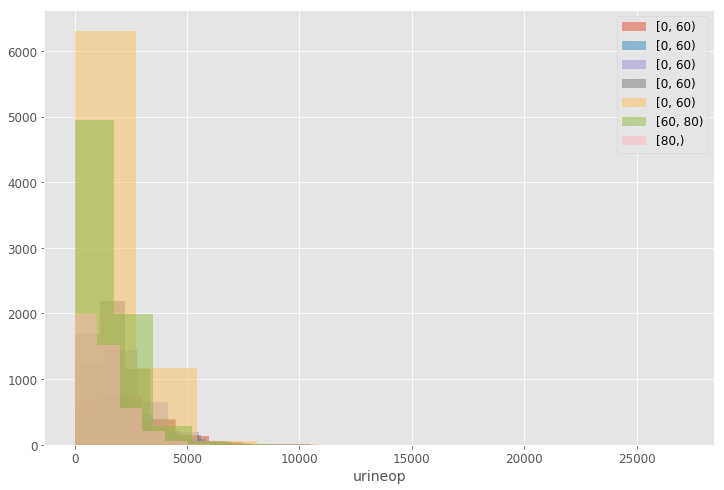

In [85]:
plot_age_group_broke_down_hist(data_train, 'urineop')

In [86]:
data_train[['urineop', 'age_group']].groupby('age_group').mean()

,urineop
age_group,
"[0, 30)",2414.773506
"[30, 40)",2203.539010
"[40, 50)",2030.559107
"[50, 60)",1847.144350
"[60, 70)",1648.190230
"[70, 80)",1446.457830
"[80,)",1264.647368


`urineop` has 8.7% missing values, but no error found, although all patients(in training set) are in the Low Abnormal Range (< 2000 ml)(dictionary Page 83)  
Data show most patients are in very low abnormal range, and less than 1000 ml doubles mortality.  Different age group has different means.

Now for temphi

In [87]:
data_train.temphi.isnull().sum() / len(data_train) * 100

8.568058636861467

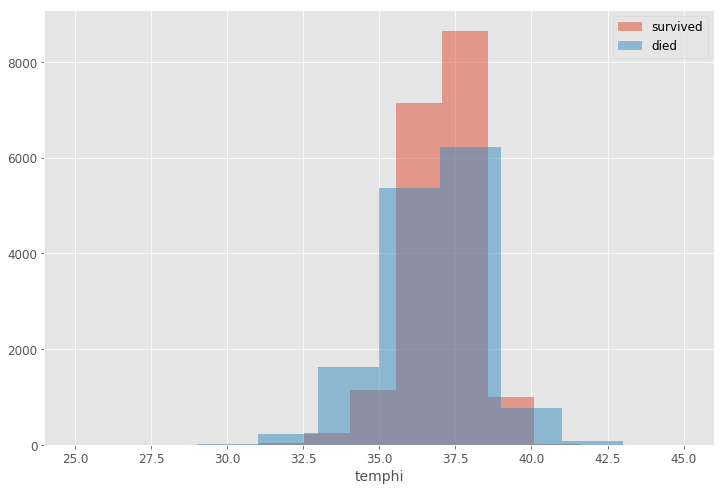

In [88]:
plot_class_broke_down_hist(data_train, 'temphi')

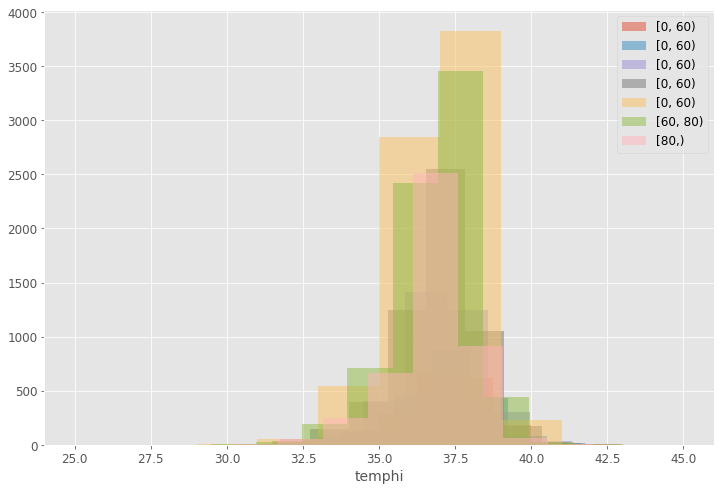

In [89]:
plot_age_group_broke_down_hist(data_train, 'temphi')

In [90]:
data_train[['temphi', 'age_group']].groupby('age_group').mean()

,temphi
age_group,
"[0, 30)",37.108935
"[30, 40)",37.107082
"[40, 50)",36.978770
"[50, 60)",36.930440
"[60, 70)",36.878393
"[70, 80)",36.847614
"[80,)",36.815228


`temphi` has 8.5% missing values, but no error found. Tempreture doesn't seem to have a difference for survived or dead patients and among age groups.

Now for rrhi

In [94]:
data_train.rrhi.isnull().sum() / len(data_train) * 100

6.7482939706254035

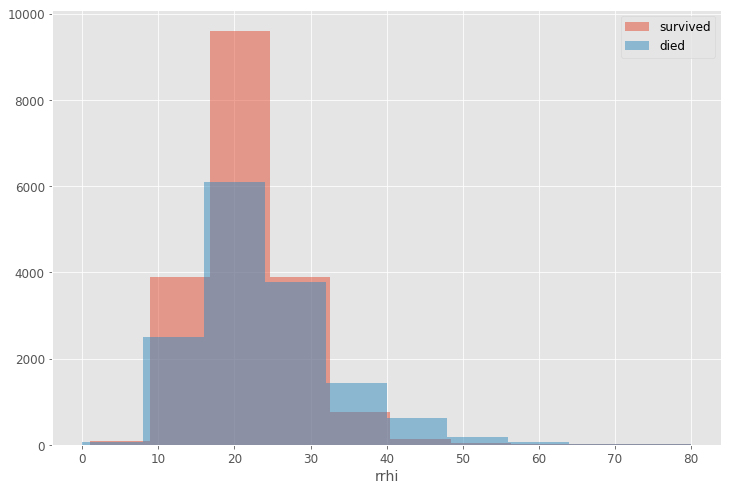

In [95]:
plot_class_broke_down_hist(data_train, 'rrhi')

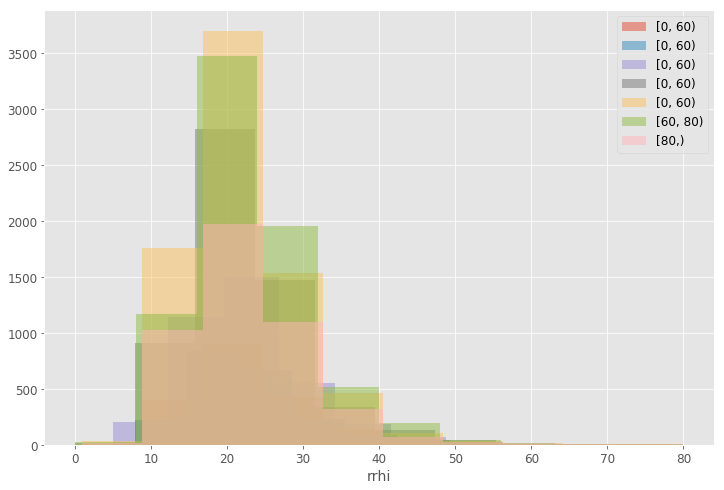

In [96]:
plot_age_group_broke_down_hist(data_train, 'rrhi')

In [97]:
data_train[['rrhi', 'age_group']].groupby('age_group').mean()

,rrhi
age_group,
"[0, 30)",23.572654
"[30, 40)",23.070693
"[40, 50)",22.549498
"[50, 60)",21.937641
"[60, 70)",21.983446
"[70, 80)",22.221697
"[80,)",22.684938


`rrhi` has 6.7% missing values, but no error found. rr doesn't seem to have a difference for survived or dead patients and among age groups.

For 24-hr physiologies, it appears no distinct pattern in the distribution across age groups. Each age group exihibits very similar distributions, and they all centered around the same mean as the ungrouped(original) mean.  

Nevertheless, let's use `age_group` to impute the missing values.

## Missing value imputation

##### Categorical variables
To fill the missing values by broken down in to age group and set to the most frequent value of corresponding group

In [98]:
data_train[categorical_vars].isna().sum()

sex               0
chr_resp          0
chr_cvs           0
chr_liv           0
chr_ren           0
immundis          0
immunrx           0
hepfail           0
lymphoma          0
metast            0
leukaem           0
immunsup          0
cirrhos           0
iddm          10682
arf              94
gcsverb        1779
gcsmotor       1769
gcseye         1772
intubated        69
ventilated       78
elect           972
dtype: int64

In [99]:
data_test[categorical_vars].isna().sum()

sex              0
chr_resp         0
chr_cvs          0
chr_liv          0
chr_ren          0
immundis         0
immunrx          0
hepfail          0
lymphoma         0
metast           0
leukaem          0
immunsup         0
cirrhos          0
iddm          1166
arf              9
gcsverb        198
gcsmotor       197
gcseye         198
intubated        9
ventilated       7
elect          110
dtype: int64

In [100]:
most_frequent_vars = []
for var in categorical_vars:
    var_group = ['age_group', var]
    # get the frequency count for each variable grouped by age group
    tmp = data_train[var_group].groupby(var_group).size().unstack() 
    tmp[var] = tmp.idxmax(axis=1) # get the value of the most frequent variable
    most_frequent_vars += [tmp[[var]]]

In [101]:
most_frequent_vars_dict_list = [dict(df) for df in most_frequent_vars]
most_frequent_vars_dict = {k: v for item in most_frequent_vars_dict_list for k, v in item.items()}
most_frequent_vars_df = pd.DataFrame.from_dict(most_frequent_vars_dict)

In [102]:
most_frequent_vars_df

,arf,chr_cvs,chr_liv,chr_ren,chr_resp,cirrhos,elect,gcseye,gcsmotor,gcsverb,hepfail,iddm,immundis,immunrx,immunsup,intubated,leukaem,lymphoma,metast,sex,ventilated
age_group,,,,,,,,,,,,,,,,,,,,,
"[0, 30)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[30, 40)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[40, 50)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[50, 60)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[60, 70)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[70, 80)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0
"[80,)",0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,M,1.0


In [103]:
most_frequent_vars_df.dtypes

arf           float64
chr_cvs       float64
chr_liv       float64
chr_ren       float64
chr_resp      float64
cirrhos         int64
elect         float64
gcseye        float64
gcsmotor      float64
gcsverb       float64
hepfail       float64
iddm          float64
immundis      float64
immunrx       float64
immunsup        int64
intubated     float64
leukaem         int64
lymphoma        int64
metast          int64
sex            object
ventilated    float64
dtype: object

In [104]:
def fillna_categorical_vars(df):
    for age_group in most_frequent_vars_df.index.values:
        for var in most_frequent_vars_df.columns.values:
            # fillna won't work inplace
            # df.loc[df.age_group == age_group, var].fillna(most_frequent_vars_df.loc[age_group, var], inplace=True)
            df.loc[(df.age_group == age_group) & df[var].isna(), var] = most_frequent_vars_df.loc[age_group, var]

In [105]:
data_test[categorical_vars].isna().sum()

sex              0
chr_resp         0
chr_cvs          0
chr_liv          0
chr_ren          0
immundis         0
immunrx          0
hepfail          0
lymphoma         0
metast           0
leukaem          0
immunsup         0
cirrhos          0
iddm          1166
arf              9
gcsverb        198
gcsmotor       197
gcseye         198
intubated        9
ventilated       7
elect          110
dtype: int64

Now fill these missing values in each dataset

In [106]:
fillna_categorical_vars(data_test)
fillna_categorical_vars(data_train)

Double check for NA values after the imputation

In [107]:
data_test[categorical_vars].isna().sum()

sex           0
chr_resp      0
chr_cvs       0
chr_liv       0
chr_ren       0
immundis      0
immunrx       0
hepfail       0
lymphoma      0
metast        0
leukaem       0
immunsup      0
cirrhos       0
iddm          0
arf           0
gcsverb       0
gcsmotor      0
gcseye        0
intubated     0
ventilated    0
elect         0
dtype: int64

In [108]:
data_train[categorical_vars].isna().sum()

sex           0
chr_resp      0
chr_cvs       0
chr_liv       0
chr_ren       0
immundis      0
immunrx       0
hepfail       0
lymphoma      0
metast        0
leukaem       0
immunsup      0
cirrhos       0
iddm          0
arf           0
gcsverb       0
gcsmotor      0
gcseye        0
intubated     0
ventilated    0
elect         0
dtype: int64

##### Continuous variables
To fill the missing values by broken down in to age group and set to the mean value of corresponding group

In [109]:
data_train[continuous_vars].isna().sum()

age                2
urineop         3103
temphi          3051
templo          3820
hrhi            2080
hrlo            3382
rrhi            2403
rrlo            3556
systolichi      2661
systoliclo      3749
diastolichi     3676
diastoliclo     4657
maphi           2284
maplo           3390
nahi            2270
nalo            4101
khi             2310
klo             4153
hco3hi          3292
hco3lo          4986
creathi         2561
creatlo         4664
hcthi           4605
hctlo           6365
hmgnhi          8989
hmgnlo         10946
wcchi           2652
wcclo           5116
plathi          8858
platlo         10922
gluchi          3025
gluclo          4497
pre_icu_hrs      240
dtype: int64

In [110]:
mean_by_age_groups = []
for var in continuous_vars:
    var_group = ['age_group', var]
    # get the frequency count for each variable grouped by age group
    mean_by_age_groups += [data_train[var_group].groupby('age_group').mean()]

In [111]:
mean_by_age_groups_dict_list = [dict(df) for df in mean_by_age_groups]
mean_by_age_groups_dict = {k: v for item in mean_by_age_groups_dict_list for k, v in item.items()}
mean_by_age_groups_df = pd.DataFrame.from_dict(mean_by_age_groups_dict)

In [112]:
mean_by_age_groups_df

,age,creathi,creatlo,diastolichi,diastoliclo,gluchi,gluclo,hco3hi,hco3lo,hcthi,hctlo,hmgnhi,hmgnlo,hrhi,hrlo,khi,klo,maphi,maplo,nahi,nalo,plathi,platlo,pre_icu_hrs,rrhi,rrlo,systolichi,systoliclo,temphi,templo,urineop,wcchi,wcclo
age_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"[0, 30)",21.639535,126.964121,95.824973,80.465399,53.938620,11.278170,6.001955,21.910424,18.307332,0.405379,0.368382,13.794803,12.430256,117.772133,75.434238,4.698673,3.719318,102.157548,66.686715,141.940374,138.049679,251.196592,206.203402,174.055360,23.572654,13.488177,143.681633,93.005266,37.108935,34.736181,2414.773506,18.854110,13.848776
"[30, 40)",35.258560,146.306685,110.368657,79.941549,54.078776,11.728592,6.180735,21.882421,18.272214,0.401829,0.365922,13.518153,12.184229,113.329330,73.133685,4.715738,3.733640,101.678605,66.557267,141.167285,137.454012,243.087822,199.149497,38.811863,23.070693,13.128986,142.817240,91.908560,37.107082,34.775230,2203.539010,18.843443,13.789583
"[40, 50)",45.376385,151.426619,116.140052,78.584681,53.378528,12.278974,6.482022,22.165912,18.599005,0.401159,0.364699,13.456060,12.141138,109.339795,70.965084,4.746440,3.784717,100.678426,65.696893,140.629940,136.841792,242.670899,199.701729,18.217319,22.549498,13.003627,142.361492,90.565734,36.978770,34.752057,2030.559107,18.753537,13.869780
"[50, 60)",55.095710,158.280160,122.340984,76.495300,52.353846,12.652720,6.734252,22.337039,18.996103,0.393414,0.358624,13.168093,11.933426,105.166838,67.321543,4.761085,3.835245,99.467602,64.827592,140.051591,136.679575,239.153579,199.909661,67.325310,21.937641,12.835059,143.281206,89.942259,36.930440,34.706658,1847.144350,18.007942,13.370847
"[60, 70)",65.074430,161.122353,128.070249,72.902549,50.018969,13.037540,6.972062,22.348184,19.140466,0.381232,0.348543,12.737208,11.574003,102.615921,64.962879,4.762337,3.881331,97.245028,63.317031,139.838563,136.699346,232.961864,196.373574,97.568598,21.983446,12.853872,144.086075,89.912559,36.878393,34.787713,1648.190230,17.302477,13.123008
"[70, 80)",74.827453,164.671860,135.717309,69.727578,47.961300,12.885671,7.082410,22.162404,19.137301,0.364958,0.333991,12.120664,11.022967,101.338229,64.411502,4.750929,3.932572,95.465871,62.194100,139.732025,136.704458,229.637193,194.572958,92.029277,22.221697,12.872564,145.458972,90.812271,36.847614,34.823716,1446.457830,16.706476,12.748854
"[80,)",84.363538,156.202352,132.837322,68.086133,46.313384,12.149543,7.209854,22.096580,19.252197,0.351376,0.323083,11.644412,10.640470,100.684964,63.604508,4.728060,4.030424,94.056378,61.151942,139.290308,136.747739,224.023766,193.480580,96.307615,22.684938,13.028137,145.281030,90.814237,36.815228,35.027932,1264.647368,16.336377,12.691626


In [113]:
def fillna_continuous_vars(df):
    for age_group in mean_by_age_groups_df.index.values:
        for var in mean_by_age_groups_df.columns.values:
            # fillna won't work inplace
            # df.loc[df.age_group == age_group, var].fillna(mean_by_age_groups_df.loc[age_group, var], inplace=True)
            df.loc[(df.age_group == age_group) & df[var].isna(), var] = mean_by_age_groups_df.loc[age_group, var]

In [114]:
data_test[continuous_vars].isna().sum()

age               0
urineop         322
temphi          330
templo          429
hrhi            231
hrlo            369
rrhi            252
rrlo            374
systolichi      298
systoliclo      417
diastolichi     413
diastoliclo     518
maphi           251
maplo           367
nahi            260
nalo            445
khi             268
klo             453
hco3hi          357
hco3lo          524
creathi         293
creatlo         504
hcthi           519
hctlo           701
hmgnhi          991
hmgnlo         1189
wcchi           304
wcclo           543
plathi          968
platlo         1175
gluchi          332
gluclo          502
pre_icu_hrs      28
dtype: int64

Fill values in both datasets

In [115]:
fillna_continuous_vars(data_test)
fillna_continuous_vars(data_train)

Double check for NA values after fill

In [118]:
data_test.isna().sum()

sex                    0
age                    0
chr_resp               0
chr_cvs                0
chr_liv                0
chr_ren                0
immundis               0
immunrx                0
hepfail                0
lymphoma               0
metast                 0
leukaem                0
immunsup               0
cirrhos                0
iddm                   0
elect                  0
pre_icu_hrs            0
intubated              0
ventilated             0
arf                    0
gcsverb                0
gcsmotor               0
gcseye                 0
urineop                0
temphi                 0
templo                 0
hrhi                   0
hrlo                   0
rrhi                   0
rrlo                   0
systolichi             0
systoliclo             0
diastolichi            0
diastoliclo            0
maphi                  0
maplo                  0
nahi                   0
nalo                   0
khi                    0
klo                    0


In [119]:
data_train.isna().sum()

sex                     0
age                     0
chr_resp                0
chr_cvs                 0
chr_liv                 0
chr_ren                 0
immundis                0
immunrx                 0
hepfail                 0
lymphoma                0
metast                  0
leukaem                 0
immunsup                0
cirrhos                 0
iddm                    0
elect                   0
pre_icu_hrs             0
intubated               0
ventilated              0
arf                     0
gcsverb                 0
gcsmotor                0
gcseye                  0
urineop                 0
temphi                  0
templo                  0
hrhi                    0
hrlo                    0
rrhi                    0
rrlo                    0
systolichi              0
systoliclo              0
diastolichi             0
diastoliclo             0
maphi                   0
maplo                   0
nahi                    0
nalo                    0
khi         

## Check dataset size before modeling

In [120]:
print('Training set shape: ',data_train.shape)
print('Test set shape: ', data_test.shape)
print('Total rows', data_train.shape[0]+data_test.shape[0])

Training set shape:  (35609, 59)
Test set shape:  (3957, 59)
Total rows 39566


## Save the cleaned dataset to files

In [122]:
data_train.to_csv('../data/cardiac_data_train_clean_{}_rows.csv'.format(len(data_train)), index=False)
data_test.to_csv('../data/cardiac_data_test_clean_{}_rows.csv'.format(len(data_test)), index=False)                  